In [20]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box
import random
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

In [21]:
with open('sample.geojson', 'r', encoding='windows-1251') as f:
    data = json.load(f)

print(json.dumps(data, ensure_ascii=False, indent=4))

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            39.787879,
                            57.44876
                        ],
                        [
                            39.789041,
                            57.448078
                        ],
                        [
                            39.794747,
                            57.450329
                        ],
                        [
                            39.791648,
                            57.450982
                        ],
                        [
                            39.787879,
                            57.44876
                        ]
                    ]
                ]
            },
            "properties": {
                "name": "Зона застройки"
            }
     

In [22]:
def Create_gdf(data:dict):

    '''Функция получает на вход данные в формате dict и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [23]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [24]:
def Plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, хранящиеся в нем.
    Обязательные полня в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

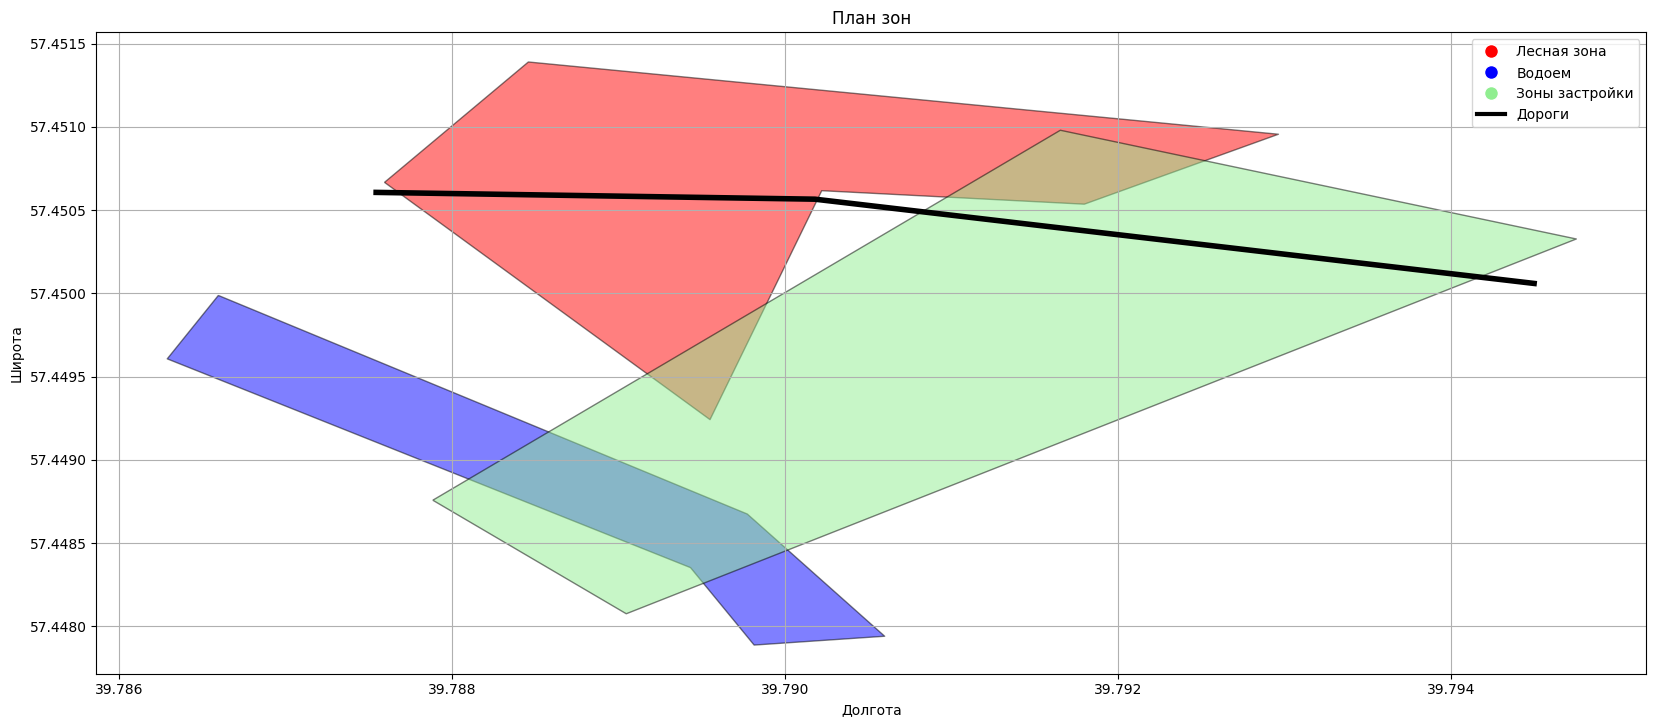

In [25]:
Plot_empty(gdf)

In [26]:
allowed_percent = 0.50
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']
combined_restricted_zones = restricted_zones.unary_union
allowed_area = total_area.difference(combined_restricted_zones).area

C:\Users\Asus\AppData\Local\Temp\ipykernel_5604\24405676.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_restricted_zones = restricted_zones.unary_union


In [27]:
def place_house(polygon, square_size, restricted_zones, placed_squares):
    attempts = 0  # Счетчик попыток
    max_attempts = 1000  # Ограничение на количество попыток

    # Определяем границы полигона
    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        # Генерируем случайные координаты внутри зоны застройки
        x = random.uniform(minx, maxx - square_size) 
        y = random.uniform(miny, maxy - square_size)

        square = box(x, y, x + square_size, y + square_size)

        # Проверяем условия
        if (
            polygon.contains(square) and 
            not restricted_zones.geometry.intersects(square).any() and 
            all(square.distance(placed_square) >= 0.0001 for placed_square in placed_squares)  # Проверяем минимальное расстояние
        ):
            return square
        
        attempts += 1  # Увеличиваем счетчик попыток

    # Если не удалось разместить квадрат, возвращаем None
    print("Нет места для размещения домов")
    return None

In [28]:
def place_park(polygon, park_size, restricted_zones, placed_parks):
    attempts = 0  # Счетчик попыток
    max_attempts = 1000  # Ограничение на количество попыток

    # Определяем границы полигона
    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        # Генерируем случайные координаты внутри зоны застройки
        x = random.uniform(minx, maxx - park_size)
        y = random.uniform(miny, maxy - park_size)

        park = box(x, y, x + park_size, y + park_size)

        # Проверяем условия
        if (
            polygon.contains(park) and 
            not restricted_zones.geometry.intersects(park).any() and 
            all(park.distance(placed_park) >= 0.0001 for placed_park in placed_parks)  # Проверяем минимальное расстояние
        ):
            return park
        
        attempts += 1  # Увеличиваем счетчик попыток

    # Если не удалось разместить квадрат, возвращаем None
    print("Нет места для размещения парков")
    return None


Допустимая площадь: 6.688176192099185e-06
Вся площадь: 7.927144500001154e-06
Допустимая площадь: 6.688176192099185e-06
Вся площадь: 7.927144500001154e-06


C:\Users\Asus\AppData\Local\Temp\ipykernel_5604\3527428171.py:81: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_park_zones = gpd.GeoSeries(parks).unary_union


Нет места для размещения домов
Застроено домов: 11.51% от доступной площади.


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


<Figure size 1200x1200 with 0 Axes>

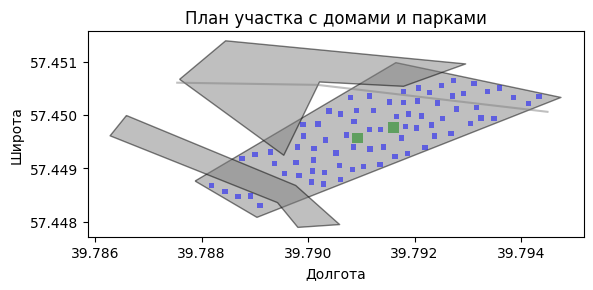

                                             geometry            name  \
0   POLYGON ((39.78788 57.44876, 39.78904 57.44808...  Зона застройки   
1   POLYGON ((39.78759 57.45067, 39.78954 57.44924...     Лесная зона   
2   POLYGON ((39.78659 57.44999, 39.78977 57.44868...          Водоем   
3   LINESTRING (39.78752 57.45061, 39.79018 57.450...          Дорога   
4   POLYGON ((39.78823 57.44862, 39.78823 57.44872...             Дом   
..                                                ...             ...   
78  POLYGON ((39.7931 57.44979, 39.7931 57.44989, ...             Дом   
79  POLYGON ((39.79224 57.44934, 39.79224 57.44944...             Дом   
80  POLYGON ((39.79209 57.4497, 39.79209 57.4498, ...             Дом   
81  POLYGON ((39.79102 57.44946, 39.79102 57.44966...            Парк   
82  POLYGON ((39.7917 57.44966, 39.7917 57.44986, ...            Парк   

            restrictions  
0                   None  
1   building not allowed  
2   building not allowed  
3   building no

In [41]:

# Функция для размещения парков
def place_park(polygon, park_size, restricted_zones, placed_parks):
    attempts = 0
    max_attempts = 1000  # Ограничение на количество попыток

    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        x = random.uniform(minx, maxx - park_size)
        y = random.uniform(miny, maxy - park_size)

        park = box(x, y, x + park_size, y + park_size)

        if (
            polygon.contains(park) and 
            not restricted_zones.intersects(park) and 
            all(park.distance(placed_park) >= 0.0001 for placed_park in placed_parks)  
        ):
            return park
        
        attempts += 1

    print("Нет места для размещения парков")
    return None

# Параметры для парков
park_size = 0.0002  # Размер стороны парка в метрах
parks = []
placed_parks = []

# Печатаем начальные условия
print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")


def place_house(polygon, square_size, restricted_zones, placed_squares):
    attempts = 0  # Счетчик попыток
    max_attempts = 1000  # Ограничение на количество попыток

    # Определяем границы полигона
    minx, miny, maxx, maxy = polygon.bounds

    while attempts < max_attempts:
        # Генерируем случайные координаты внутри зоны застройки
        x = random.uniform(minx, maxx - square_size) 
        y = random.uniform(miny, maxy - square_size)

        square = box(x, y, x + square_size, y + square_size)

        # Проверяем условия
        if (
            polygon.contains(square) and 
            not restricted_zones.intersects(square) and 
            all(square.distance(placed_square) >= 0.0001 for placed_square in placed_squares)  # Проверяем минимальное расстояние
        ):
            return square
        
        attempts += 1  # Увеличиваем счетчик попыток

    print("Нет места для размещения домов")
    return None

# Далее, в основном коде
# Параметры для домов
square_size = 0.0001  # размер стороны квадрата в метрах
squares = []
used_area = 0
placed_squares = []

# Печатаем начальные условия
print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

# Размещение двух парков
for _ in range(2):
    park = place_park(total_area, park_size, combined_restricted_zones, placed_parks)
    if park:
        parks.append(park)
        placed_parks.append(park)
        
# Обновляем restricted_zones с зонами парков
if parks:
    combined_park_zones = gpd.GeoSeries(parks).unary_union
    combined_restricted_zones = combined_restricted_zones.union(combined_park_zones)

# Размещение домов
while used_area < allowed_area * allowed_percent:
    square = place_house(total_area, square_size, combined_restricted_zones, placed_squares)
    
    if square:  
        squares.append(square)
        placed_squares.append(square)
        used_area += square.area
    else:
        break 


# Расчет процентов и финальная проверка
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено домов: {percentage_used:.2f}% от доступной площади.")

# Создаем GeoDataFrame для размещенных домов
squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
squares_gdf['name'] = 'Дом'
squares_gdf['restrictions'] = None

# Создаем GeoDataFrame для размещенных парков
parks_gdf = gpd.GeoDataFrame(geometry=parks, crs=gdf.crs)
parks_gdf['name'] = 'Парк'

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, squares_gdf, parks_gdf], ignore_index=True)

# Сохранение в GeoJSON
final_gdf.to_file("site_plan.geojson", driver='GeoJSON')

# Визуализация плана участка с домами и парками
plt.figure(figsize=(12, 12))
base = gdf.plot(color='gray', edgecolor='k', alpha=0.5)
squares_gdf.plot(ax=base, color='blue', alpha=0.5)
parks_gdf.plot(ax=base, color='green', alpha=0.5)
plt.title("План участка с домами и парками")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.savefig("site_plan_with_parks.png")  # Сохранение плана
plt.show()

# Для подтверждения, можно вывести результат
print(f'{final_gdf}\nЗанятая площадь: {used_area}\nДоступная площадь: {allowed_area}')
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено домов: {percentage_used:.2f}% от доступной площади.")


In [29]:
# Параметры квадрата
square_size = 0.0001  # размер стороны квадрата в метрах

squares = []
used_area = 0
placed_squares = []

# Печатаем начальные условия
print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

while used_area < allowed_area * allowed_percent:
    square = place_house(total_area, square_size, restricted_zones, placed_squares)
    
    if square:  # Проверьте, создан ли квадрат
        squares.append(square)
        placed_squares.append(square)
        used_area += square.area
    else:
        break 

# Расчет процентов и финальная проверка
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено {percentage_used:.2f}% от доступной площади.")

squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
squares_gdf['name'] = 'Дом'
squares_gdf['restrictions'] = None  # В случае, если для домов нет ограничений

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, squares_gdf], ignore_index=True)

# Для подтверждения, можно вывести результат
print(f'{final_gdf}\nЗанятая площадь: {used_area}\nДоступная площадь: {allowed_area}')
percentage_used = (used_area / allowed_area) * 100
print(f"Застроено {percentage_used:.2f}% от доступной площади.")

Допустимая площадь: 6.688176192099185e-06
Вся площадь: 7.927144500001154e-06
Нет места для размещения домов
Застроено 12.41% от доступной площади.
                                             geometry            name  \
0   POLYGON ((39.78788 57.44876, 39.78904 57.44808...  Зона застройки   
1   POLYGON ((39.78759 57.45067, 39.78954 57.44924...     Лесная зона   
2   POLYGON ((39.78659 57.44999, 39.78977 57.44868...          Водоем   
3   LINESTRING (39.78752 57.45061, 39.79018 57.450...          Дорога   
4   POLYGON ((39.79043 57.44986, 39.79043 57.44996...             Дом   
..                                                ...             ...   
82  POLYGON ((39.79244 57.45061, 39.79244 57.45071...             Дом   
83  POLYGON ((39.78913 57.44933, 39.78913 57.44943...             Дом   
84  POLYGON ((39.79191 57.44958, 39.79191 57.44968...             Дом   
85  POLYGON ((39.78887 57.44917, 39.78887 57.44927...             Дом   
86  POLYGON ((39.79174 57.45044, 39.79174 57.45054

In [30]:
# allowed_percent = 0.50
# total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
# restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']
# combined_restricted_zones = restricted_zones.unary_union
# allowed_area = total_area.difference(combined_restricted_zones).area
# num_parks = 2


# def place_house(polygon, square_size, restricted_zones, placed_squares):
#     attempts = 0  # Счетчик попыток
#     max_attempts = 1000  # Ограничение на количество попыток

#     # Определяем границы полигона
#     minx, miny, maxx, maxy = polygon.bounds

#     while attempts < max_attempts:
#         # Генерируем случайные координаты внутри зоны застройки
#         x = random.uniform(minx, maxx - square_size) 
#         y = random.uniform(miny, maxy - square_size)

#         square = box(x, y, x + square_size, y + square_size)

#         # Проверяем условия
#         if (
#             polygon.contains(square) and 
#             not restricted_zones.geometry.intersects(square).any() and 
#             all(square.distance(placed_square) >= 0.0001 for placed_square in placed_squares)  # Проверяем минимальное расстояние
#         ):
#             return square
        
#         attempts += 1  # Увеличиваем счетчик попыток

#     # Если не удалось разместить квадрат, возвращаем None
#     print("Нет места для размещения домов")
#     return None

# def place_park(polygon, park_size, restricted_zones, placed_parks):
#     attempts = 0  # Счетчик попыток
#     max_attempts = 1000  # Ограничение на количество попыток

#     # Определяем границы полигона
#     minx, miny, maxx, maxy = polygon.bounds

#     while attempts < max_attempts:
#         # Генерируем случайные координаты внутри зоны застройки
#         x = random.uniform(minx, maxx - park_size) 
#         y = random.uniform(miny, maxy - park_size)

#         park = box(x, y, x + park_size, y + park_size)

#         # Проверяем условия
#         if (
#             polygon.contains(park) and 
#             not restricted_zones.geometry.intersects(park).any() and 
#             all(park.distance(placed_park) >= 0.0001 for placed_park in placed_parks)  # Проверяем минимальное расстояние
#         ):
#             return park
        
#         attempts += 1  # Увеличиваем счетчик попыток

#     # Если не удалось разместить квадрат, возвращаем None
#     print("Нет места для размещения домов")
#     return None

# # Параметры квадрата
# square_size = 0.0001  # размер стороны квадрата в метрах
# park_size = 0.0005
# squares = []
# parks = []
# used_area = 0
# placed_squares = []
# placed_parks = []
# num_park = 0

# # Печатаем начальные условия
# print(f"Допустимая площадь: {allowed_area}\nВся площадь: {total_area.area}")

# while used_area < allowed_area * allowed_percent:
#     if num_park < num_parks:
#         park = place_park(total_area, park_size, restricted_zones, placed_parks)
#     square = place_house(total_area, square_size, restricted_zones, placed_squares)
    
#     if square:  # Проверьте, создан ли квадрат
#         squares.append(square)
#         placed_squares.append(square)
#         used_area += square.area
#     elif park:
#         parks.append(park)
#         placed_parks.append(parks)
#         used_area += park.area
#     else:
#         break 

# # Расчет процентов и финальная проверка
# percentage_used = (used_area / allowed_area) * 100
# print(f"Застроено {percentage_used:.2f}% от доступной площади.")

# squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
# squares_gdf['name'] = 'Дом'
# squares_gdf['restrictions'] = None  # В случае, если для домов нет ограничений

# # Объединяем со старым GeoDataFrame
# final_gdf = pd.concat([gdf, squares_gdf], ignore_index=True)

# # Для подтверждения, можно вывести результат
# print(f'{final_gdf}\nЗанятая площадь: {used_area}\nДоступная площадь: {allowed_area}')
# percentage_used = (used_area / allowed_area) * 100
# print(f"Застроено {percentage_used:.2f}% от доступной площади.")

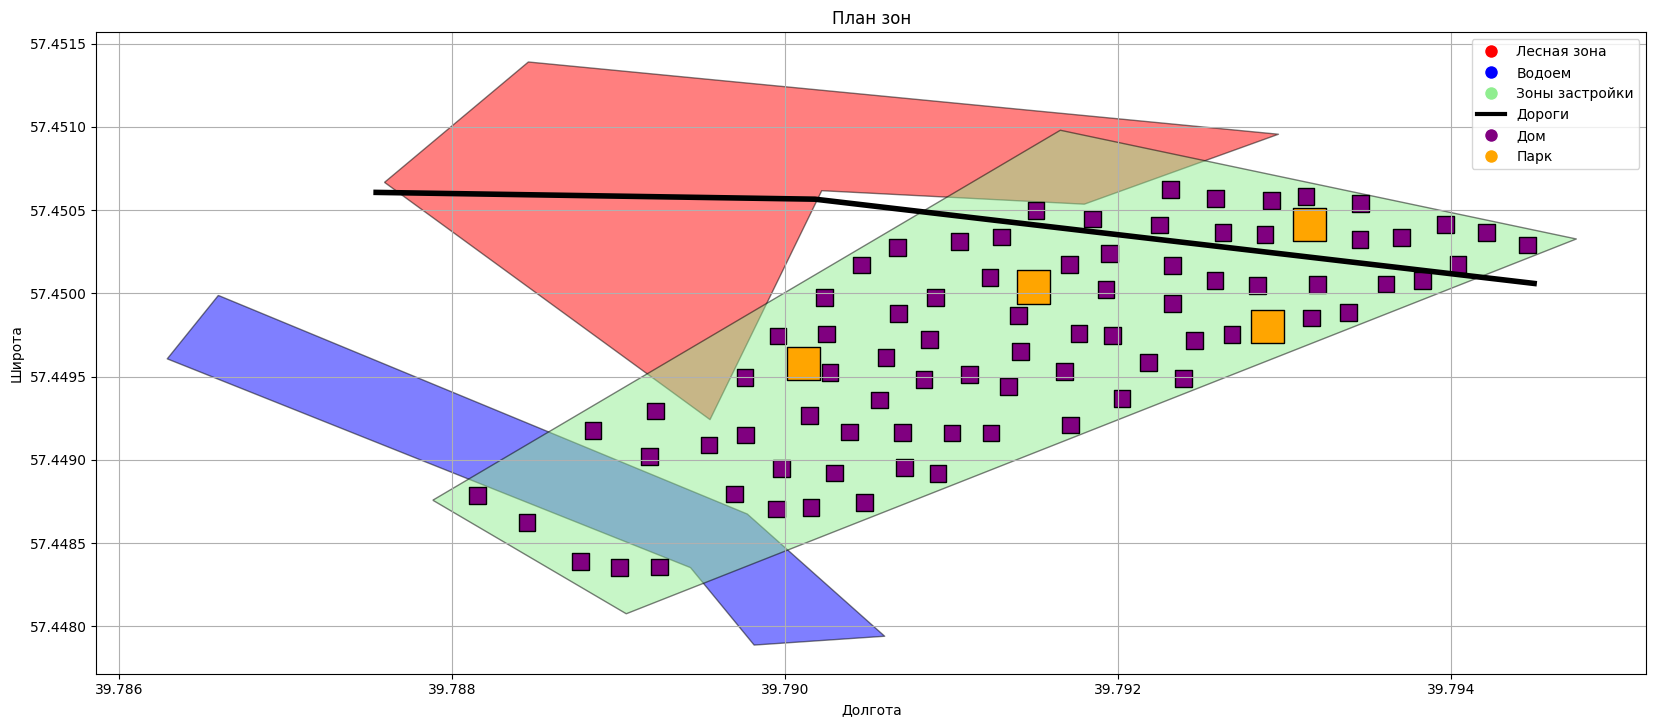

In [40]:
fig, ax = plt.subplots(figsize=(20, 40))

# Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
forest_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Лесная зона')]
water_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Водоем')]
building_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Зона застройки')]
roads = final_gdf[final_gdf['geometry'].type == 'LineString']
houses = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Дом')]
parks = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Парк')]

# Плотим зомы
forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=4, legend=False)
building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)
houses.plot(ax=ax, color='purple', edgecolor='black', legend=False)
parks.plot(ax=ax, color='orange', edgecolor='black', legend=False)

# Задаем легенду
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги'),
    plt.Line2D([0], [0], marker='o', color='w', label='Дом', markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Парк', markerfacecolor='orange', markersize=10)
]

ax.legend(handles=handles)
ax.set_title('План зон')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid()
plt.show()

In [32]:
# import random
# from shapely.geometry import LineString, Point, Polygon
# import geopandas as gpd

# def place_broken_line(polygon, num_points=5):
#     # Список контрольных точек
#     control_points = []
    
#     # Получаем границы полигона
#     minx, miny, maxx, maxy = polygon.bounds

#     while len(control_points) < num_points:
#         # Генерируем случайные координаты внутри границ полигона
#         x = random.uniform(minx, maxx)
#         y = random.uniform(miny, maxy)
#         point = Point(x, y)
        
#         # Проверяем, находится ли точка внутри полигона
#         if polygon.contains(point):
#             control_points.append(point)
    
#     # Сортируем контрольные точки по их x-координатам
#     control_points.sort(key=lambda p: p.x)
    
#     # Создаем линию из контрольных точек
#     broken_line = LineString([point for point in control_points])
    
#     return broken_line

# # Пример использования функции
# # Создайте тестовый полигон
# polygon = Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])
# broken_line = place_broken_line(polygon, num_points=10)

# # Преобразуем в GeoDataFrame для визуализации (если необходимо)
# gdf = gpd.GeoDataFrame(geometry=[polygon, broken_line], crs="EPSG:4326")
# print(gdf)

# # Если нужно, визуализируйте результаты
# import matplotlib.pyplot as plt

# gdf.boundary.plot(color='black')
# plt.show()
